# Model Development

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [2]:
# Replace with the path to Chicago dataset
chicago_filepath = "Chicago_after_FE.csv"
# Replace with the path to NIBRS test dataset
NIBRS_filepath = "NIBRS_after_FE.csv"

# Read the dataset
chicago_df = pd.read_csv(chicago_filepath)
NIBRS_df = pd.read_csv(NIBRS_filepath)

/var/folders/rm/zkx7tx614cq0pcwp0cpgbhy80000gn/T/ipykernel_12189/3116578832.py:8: DtypeWarning: Columns (8,9,10,12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  NIBRS_df = pd.read_csv(NIBRS_filepath)


In [3]:
# Check Date Range
c_min_date = chicago_df['date'].min()
c_max_date = chicago_df['date'].max()
n_min_date = NIBRS_df['date'].min()
n_max_date = NIBRS_df['date'].max()
print(f"Chicago Dataset Date Range: {c_min_date} to {c_max_date}")
print(f"NIBRS Dataset Date Range: {n_min_date} to {n_max_date}")

Chicago Dataset Date Range: 2020-07-31 17:29:00 to 2025-03-16 03:00:00
NIBRS Dataset Date Range: 2023-01-01 00:00:00 to 2023-12-31 23:00:00


In [4]:
chicago_df['date'] = pd.to_datetime(chicago_df['date'])
# Choose data from 2021-01-01 to 2022-12-31 for model training and initial testing
filtered_df = chicago_df[(chicago_df['date'] >= '2021-01-01') & (chicago_df['date'] <= '2022-12-31')]

print(f"Chicago Dataset Date Range After Filtering: {filtered_df['date'].min()}, {filtered_df['date'].max()}")

Chicago Dataset Date Range After Filtering: 2021-01-01 00:00:00, 2022-12-31 00:00:00


In [5]:
chicago_df = filtered_df
print("Chicago dataset shape:", chicago_df.shape)

Chicago dataset shape: (448489, 32)


In [6]:
NIBRS_df.shape

(562976, 37)

## Feature Processing

In [7]:
feature_columns = [
    'arrest', 'UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday', 
    'is_weekend', 'is_holiday', 'crime_against', 'offense_category_name'
]

chicago_df = chicago_df[feature_columns]

In [8]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [ ]:
# X = chicago_df.drop(columns=['arrest']) 
# y = chicago_df['arrest']

# # split train and test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## Issues Found

In [ ]:
# # Check the distribution of labels in the original dataset and the split datasets
# print("Original label distribution:")
# print(y.value_counts(normalize=True))
# print("\nTraining label distribution:")
# print(y_train.value_counts(normalize=True))
# print("\nTesting label distribution:")
# print(y_test.value_counts(normalize=True))

Original label distribution:
arrest
False    0.878149
True     0.121851
Name: proportion, dtype: float64

Training label distribution:
arrest
False    0.878149
True     0.121851
Name: proportion, dtype: float64

Testing label distribution:
arrest
False    0.878147
True     0.121853
Name: proportion, dtype: float64


In [ ]:
# chicago_df.head(3)

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
561727,False,2,12,31,0,5,1,0,Property,Destruction/Damage/Vandalism of Property
561728,False,2,12,31,0,5,1,0,Property,Larceny/Theft Offenses
561729,False,10,12,31,0,5,1,0,Society,Trespass of Real Property


In [ ]:
# X_train.head(3)

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
776192,1,2,17,3,3,0,0,Person,Assault Offenses
783591,1,2,3,20,3,0,0,Property,Destruction/Damage/Vandalism of Property
949169,9,4,30,15,4,0,0,Person,Assault Offenses


In [ ]:
# y_train.head(3)
# y_train.value_counts()

776192    False
783591     True
949169    False
Name: arrest, dtype: bool

## Model Training

### Perceptron Classifier 
The Perceptron, as a single-layer neural network, was selected for this arrest prediction task due to its distinct advantages in handling the given feature space (crime type, time, and location) and its fundamental algorithmic differences from the previously attempted CatBoost model.  

**Key Justifications:**  
1. **Linear Separability Prioritization**  
   - Given that arrest decisions may rely on threshold-based patterns (e.g., specific crime types or locations triggering higher arrest probabilities), the Perceptron’s linear decision boundary can efficiently capture such deterministic rules. Unlike tree-based models that partition feature space hierarchically, the Perceptron directly learns a hyperplane, potentially revealing simpler but legally actionable decision patterns.  

2. **Temporal Feature Efficiency**  
   - Time-based features (e.g., hour of day, day of week) often exhibit cyclical linear relationships with arrest rates (e.g., higher arrests during nighttime). The Perceptron’s weight-based learning mechanism can explicitly quantify these periodic trends through learned coefficients, whereas tree models may over-fragment temporal patterns.  

3. **Computational Scalability**  
   - For a dataset with spatially dense location data (e.g., latitude/longitude coordinates), the Perceptron’s O(*n*) training complexity outperforms ensemble methods when processing high-frequency updates. This aligns with real-world policing needs where rapid model retraining may be required.  

4. **Interpretability Trade-off**  
   - While less interpretable than decision trees, the Perceptron’s weights provide direct feature importance metrics (e.g., high-magnitude weights for violent crime types). This offers a middle ground between CatBoost’s complex feature interactions and purely linear models like logistic regression.  

temp
<!-- For `arrest` feature, it is extremely imbalanced with highly unarrested proportion.

For `Perception` model, we will use `SGDClassifier` with `log` loss function. The `log` loss function is used for binary classification problems and is suitable for our task of predicting arrests. The `SGDClassifier` is a linear classifier that uses stochastic gradient descent to optimize the model parameters. It is efficient for large datasets and can handle online learning scenarios. -->


In [23]:
# 定义特征类型
numeric_features = ['UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday']
binary_features = ['is_weekend', 'is_holiday']
categorical_features = ['crime_against', 'offense_category_name']

# 预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# 构建Perceptron模型管道
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', Perceptron(
        penalty='l2',
        alpha=0.001,
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

# 划分数据集
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 训练模型
model.fit(X_train, y_train)

# 获取决策分数
y_scores = model.decision_function(X_test)

# 通过精确率-召回率曲线优化阈值
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1最大化
optimal_threshold = thresholds[optimal_idx]

# 应用优化后的阈值
y_pred_optimized = (y_scores > optimal_threshold).astype(int)

# 输出评估结果
print("Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized))

print("\nConfusion Matrix (Optimized Threshold):")
print(confusion_matrix(y_test, y_pred_optimized))

# # 特征重要性分析
# if hasattr(model.named_steps['classifier'], 'coef_'):
#     # 获取特征名称
#     num_features = numeric_features + binary_features
#     cat_encoder = model.named_steps['preprocessor'].named_transformers_['cat']
#     cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)
#     all_features = num_features + list(cat_feature_names)
    
#     # 提取权重
#     weights = model.named_steps['classifier'].coef_[0]
#     feature_importance = pd.DataFrame({'feature': all_features, 'weight': weights})
#     print("\nTop 10 Positive Weight Features:")
#     print(feature_importance.sort_values('weight', ascending=False).head(10))
#     print("\nTop 10 Negative Weight Features:")
#     print(feature_importance.sort_values('weight').head(10))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

       False       0.91      0.86      0.89     78768
        True       0.29      0.41      0.34     10930

    accuracy                           0.81     89698
   macro avg       0.60      0.64      0.61     89698
weighted avg       0.84      0.81      0.82     89698


Confusion Matrix (Optimized Threshold):
[[67774 10994]
 [ 6422  4508]]


In [21]:
# 获取决策分数（非概率）
y_scores = model.decision_function(X_test)

# 通过精确率-召回率曲线找最佳阈值
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 找到使F1最大化的阈值
optimal_idx = np.argmax(2 * precision * recall / (precision + recall))
optimal_threshold = thresholds[optimal_idx]

# 应用新阈值
y_pred_optimized = (y_scores > optimal_threshold).astype(int)
print(classification_report(y_test, y_pred_optimized))

              precision    recall  f1-score   support

       False       0.91      0.86      0.89     78768
        True       0.29      0.41      0.34     10930

    accuracy                           0.81     89698
   macro avg       0.60      0.64      0.61     89698
weighted avg       0.84      0.81      0.82     89698



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

In [29]:


# 定义特征类型
numeric_features = ['UNIFIED_LOCATION_CODE', 'month', 'day', 'hour', 'weekday']
binary_features = ['is_weekend', 'is_holiday']
categorical_features = ['crime_against', 'offense_category_name']

# 预处理管道
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# 构建SGDClassifier模型管道
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log',  # 使用log loss进行二分类
        penalty='l2',
        alpha=0.001,
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    ))
])

# 划分数据集
X = chicago_df.drop(columns=['arrest'])
y = chicago_df['arrest']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# 训练模型
model.fit(X_train, y_train)

# 获取决策分数
y_scores = model.decision_function(X_test)

# 通过精确率-召回率曲线优化阈值
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(2 * precision * recall / (precision + recall))  # F1最大化
optimal_threshold = thresholds[optimal_idx]

# 应用优化后的阈值
y_pred_optimized = (y_scores > optimal_threshold).astype(int)

# 输出评估结果
print("Classification Report (Optimized Threshold):")
print(classification_report(y_test, y_pred_optimized))

print("\nConfusion Matrix (Optimized Threshold):")
print(confusion_matrix(y_test, y_pred_optimized))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

Classification Report (Optimized Threshold):
              precision    recall  f1-score   support

       False       0.93      0.97      0.95     78768
        True       0.68      0.46      0.55     10930

    accuracy                           0.91     89698
   macro avg       0.80      0.72      0.75     89698
weighted avg       0.90      0.91      0.90     89698


Confusion Matrix (Optimized Threshold):
[[76392  2376]
 [ 5879  5051]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

### Optimize Parameters
TODO: with my local limited computational resources, it's hard to train :(

In [ ]:
# param_dist = {
#     'depth': [4, 6],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'scale_pos_weight': [arrest_weight, arrest_weight * 1.5],
#     'border_count': [32, 64]
# }

# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=10,
#     scoring='f1',
#     cv=2,
#     verbose=1,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best Params:", random_search.best_params_)

## Test Model In NIBRS

In [25]:
NIBRS_df = NIBRS_df[feature_columns]
NIBRS_df.head()

,arrest,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name
0,True,1,1,19,21,3,0,0,Person,Assault Offenses
1,True,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property
2,True,1,4,13,13,3,0,0,Person,Assault Offenses
3,True,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses
4,True,1,5,20,15,5,1,0,Person,Assault Offenses


In [26]:
# handle missing value
print(chicago_df.isnull().sum())
chicago_df = chicago_df.dropna()
print(chicago_df.isnull().sum())

arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64
arrest                   0
UNIFIED_LOCATION_CODE    0
month                    0
day                      0
hour                     0
weekday                  0
is_weekend               0
is_holiday               0
crime_against            0
offense_category_name    0
dtype: int64


In [27]:
X_NIBRS_test = NIBRS_df.drop(columns=['arrest']) 
y_NIBRS_test = NIBRS_df['arrest']

In [30]:
# Keep the same columns sequences as in the training set
X_NIBRS_test = X_NIBRS_test[X_train.columns]

y_NIBRS_pred = model.predict(X_NIBRS_test)

print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.84      0.86    467171
        True       0.38      0.49      0.43     95805

    accuracy                           0.78    562976
   macro avg       0.64      0.66      0.65    562976
weighted avg       0.80      0.78      0.79    562976



# Model Evaluation

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

## Standard Classification Metrics

In [32]:
print("Chicago Classification Report:\n", classification_report(y_test, y_pred))
print("NIBRS Classification Report:\n", classification_report(y_NIBRS_test, y_NIBRS_pred))

Chicago Classification Report:
               precision    recall  f1-score   support

       False       0.93      0.63      0.75     78768
        True       0.20      0.68      0.31     10930

    accuracy                           0.63     89698
   macro avg       0.57      0.65      0.53     89698
weighted avg       0.84      0.63      0.70     89698

NIBRS Classification Report:
               precision    recall  f1-score   support

       False       0.89      0.84      0.86    467171
        True       0.38      0.49      0.43     95805

    accuracy                           0.78    562976
   macro avg       0.64      0.66      0.65    562976
weighted avg       0.80      0.78      0.79    562976



In [33]:
# calculate ROC AUC score
# for Chicago test set
y_proba = model.predict_proba(X_test)[:, 1]
c_auc_score = roc_auc_score(y_test, y_proba)
print("Chicago ROC-AUC Score:", c_auc_score)

# for NIBRS test set
y_NIBRS_proba = model.predict_proba(X_NIBRS_test)[:, 1]
n_auc_score = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)
print("NIBRS ROC-AUC Score:", n_auc_score)

Chicago ROC-AUC Score: 0.8200581655342225


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py

NIBRS ROC-AUC Score: 0.7229073816018879


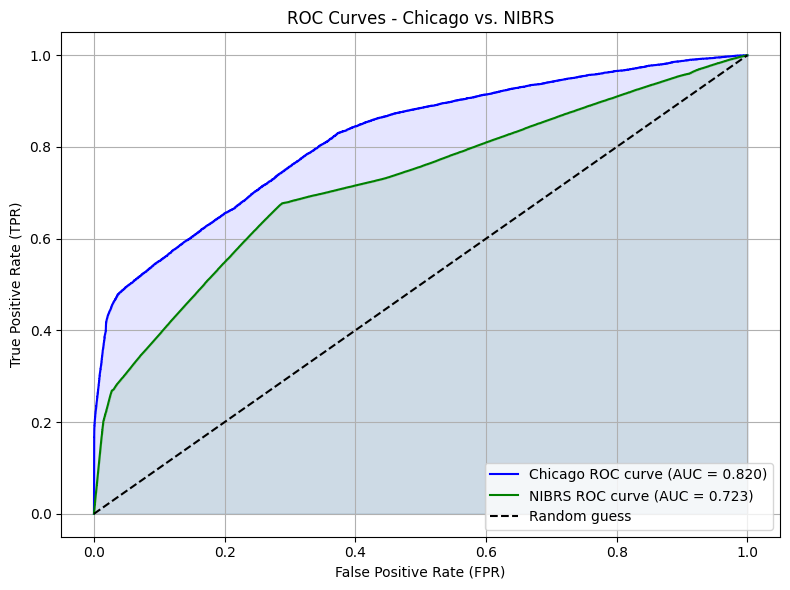

In [34]:
# Plot ROC Curves
fpr_c, tpr_c, _ = roc_curve(y_test, y_proba)
auc_c = roc_auc_score(y_test, y_proba)
fpr_n, tpr_n, _ = roc_curve(y_NIBRS_test, y_NIBRS_proba)
auc_n = roc_auc_score(y_NIBRS_test, y_NIBRS_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_c, tpr_c, label=f'Chicago ROC curve (AUC = {auc_c:.3f})', color='blue')
plt.plot(fpr_n, tpr_n, label=f'NIBRS ROC curve (AUC = {auc_n:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.fill_between(fpr_c, tpr_c, alpha=0.1, color='blue')
plt.fill_between(fpr_n, tpr_n, alpha=0.1, color='green')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves - Chicago vs. NIBRS')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Temporal Accuracy Measures

In [35]:
def concat_eval_df(X_test, y_test, y_pred):
    eval_df = X_test.reset_index(drop=True).copy()

    eval_df['y_true'] = pd.Series(y_test).reset_index(drop=True)
    eval_df['y_pred'] = pd.Series(y_pred).reset_index(drop=True)

    return eval_df

In [36]:
# Create evaluation DataFrame for Chicago test set
eval_df_chicago = concat_eval_df(X_test, y_test, y_pred)

# Create evaluation DataFrame for NIBRS test set
eval_df_NIBRS = concat_eval_df(X_NIBRS_test, y_NIBRS_test, y_NIBRS_pred)

In [37]:
eval_df_chicago.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,10,9,18,10,5,1,0,Person,Assault Offenses,False,True
1,1,4,30,22,5,1,0,Person,Assault Offenses,False,True
2,2,6,12,8,6,1,0,Property,Larceny/Theft Offenses,False,True
3,2,6,17,11,4,0,0,Person,Assault Offenses,False,True
4,1,5,28,0,5,1,0,Person,Assault Offenses,False,True


In [38]:
eval_df_NIBRS.head()

,UNIFIED_LOCATION_CODE,month,day,hour,weekday,is_weekend,is_holiday,crime_against,offense_category_name,y_true,y_pred
0,1,1,19,21,3,0,0,Person,Assault Offenses,True,True
1,1,2,8,18,2,0,0,Property,Destruction/Damage/Vandalism of Property,True,False
2,1,4,13,13,3,0,0,Person,Assault Offenses,True,True
3,2,4,13,21,3,0,0,Society,Drug/Narcotic Offenses,True,True
4,1,5,20,15,5,1,0,Person,Assault Offenses,True,True


In [39]:
def evaluate_temporal_performance(df, group_col, y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index()

    return grouped_perf

In [40]:
# Note: df1 is for Chicago, df2 is for NIBRS
def plot_temporal_comparison(df1, df2, x_col, dataset_names=('Chicago', 'NIBRS'), title_prefix=''):

    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    titles = ['Accuracy', 'F1 Score', 'Precision', 'Recall']

    df1 = df1.sort_values(by=x_col)
    df2 = df2.sort_values(by=x_col)
    x_vals = df1[x_col]

    fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2
        ax = axs[row][col]

        ax.plot(x_vals, df1[metric], marker='o', label=dataset_names[0], color='blue')
        ax.plot(x_vals, df2[metric], marker='s', label=dataset_names[1], color='green', linestyle='--')

        ax.set_title(f'{titles[i]} by {x_col.capitalize()}', fontsize=12)
        ax.set_xlabel(x_col.capitalize())
        ax.set_ylabel(titles[i])
        ax.set_xticks(sorted(x_vals.unique()))
        ax.grid(True)
        ax.legend()

    plt.suptitle(f'{title_prefix} Performance Comparison: {dataset_names[0]} vs {dataset_names[1]}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [41]:
def plot_binary_group_bars_split(df1, df2, group_col='is_weekend', dataset_names=('Chicago', 'NIBRS'), title_prefix=''):
    metrics = ['accuracy', 'f1_score', 'precision', 'recall']
    df1 = df1.sort_values(by=group_col)
    df2 = df2.sort_values(by=group_col)

    categories = sorted(df1[group_col].unique())  # e.g. [0, 1]
    bar_width = 0.2
    x = np.arange(len(categories))
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=False)

    for i, metric in enumerate(metrics):
        ax = axs[i]
        
        df1_scores = df1.set_index(group_col)[metric].loc[categories]
        df2_scores = df2.set_index(group_col)[metric].loc[categories]

        ax.bar(x - bar_width/2, df1_scores, width=bar_width, label=dataset_names[0], color='blue')
        ax.bar(x + bar_width/2, df2_scores, width=bar_width, label=dataset_names[1], color='green', hatch='//')

        ax.set_title(metric.title(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels([f'{group_col}={c}' for c in categories])
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")
        ax.grid(axis='y')
        if i == 0:
            ax.legend()

    plt.suptitle(f'{title_prefix} Performance by {group_col}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

### Evaluate Performance in Hour

In [42]:
# Evaluate performance in Hour for Chicago test set
hourly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='hour')
print("Performance in Hour for Chicago test set: \n", hourly_perf_chicago)
# Evaluate performance in Hour for NIBRS test set
hourly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='hour')
print("Performance in Hour for NIBRS test set: \n", hourly_perf_NIBRS)

Performance in Hour for Chicago test set: 
     hour  accuracy  f1_score  precision    recall   count
0      0  0.654585  0.275921   0.171398  0.707174  7339.0
1      1  0.543014  0.267108   0.167822  0.654054  2906.0
2      2  0.550790  0.257463   0.159231  0.672078  2658.0
3      3  0.564009  0.208437   0.123047  0.681081  2195.0
4      4  0.584334  0.212351   0.127108  0.644737  1749.0
5      5  0.589050  0.187744   0.112150  0.576000  1516.0
6      6  0.629464  0.171184   0.102916  0.508475  1568.0
7      7  0.646455  0.238956   0.149123  0.601010  2144.0
8      8  0.657956  0.247453   0.155109  0.611511  3023.0
9      9  0.660650  0.272928   0.173333  0.641558  3878.0
10    10  0.656527  0.358732   0.239268  0.716446  3945.0
11    11  0.655243  0.412380   0.285456  0.742543  3910.0
12    12  0.672272  0.325600   0.212635  0.694631  5233.0
13    13  0.642823  0.329778   0.217979  0.677007  4222.0
14    14  0.634712  0.309222   0.199883  0.682635  4183.0
15    15  0.639653  0.258598

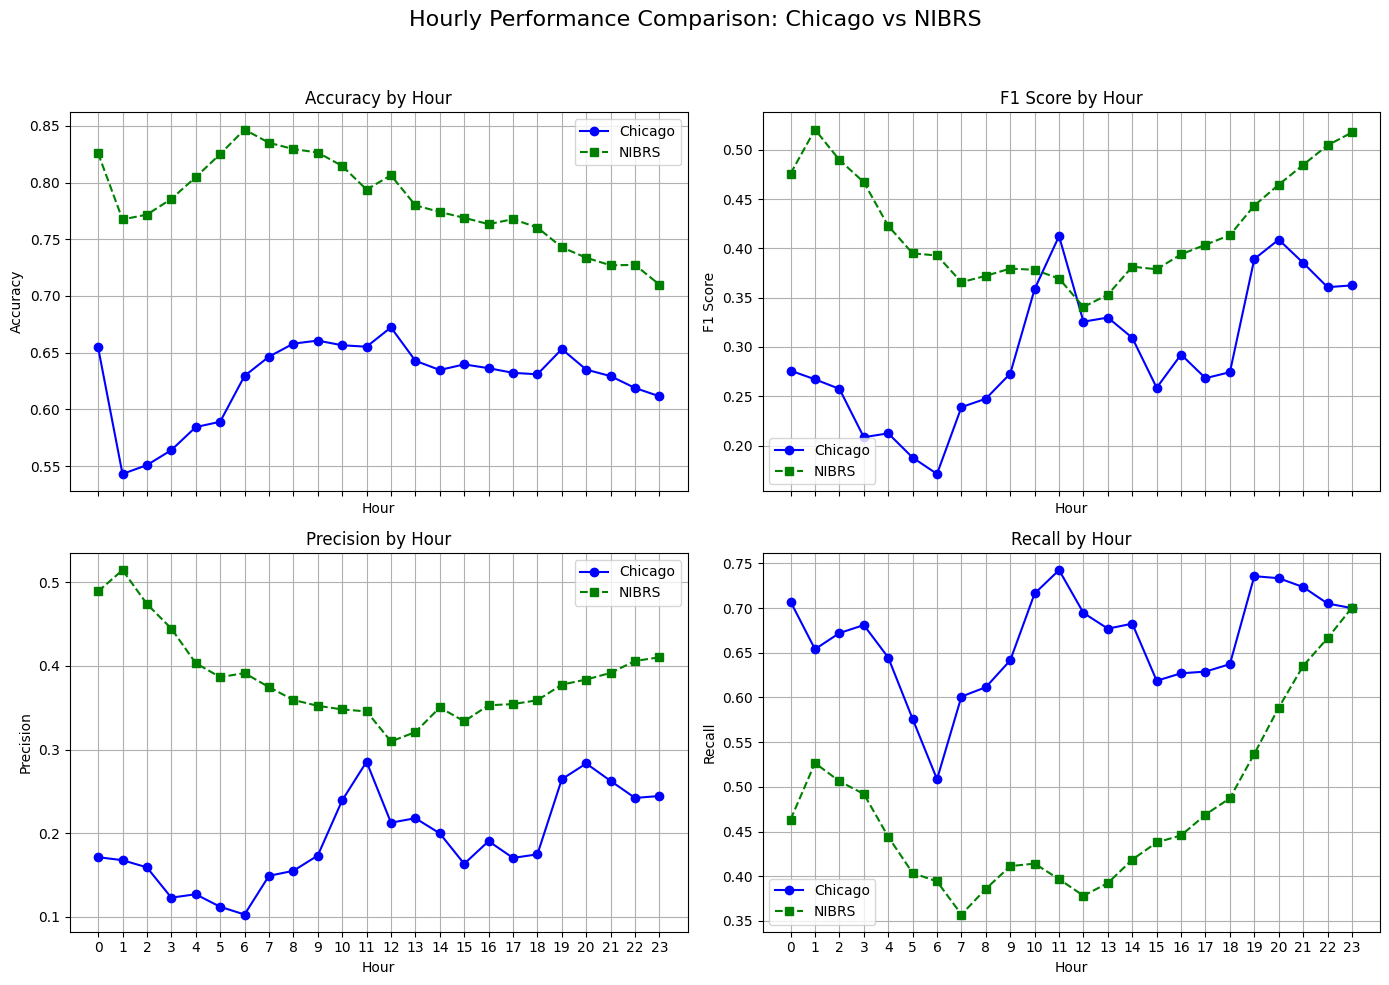

In [43]:
hourly_perf_chicago = hourly_perf_chicago.sort_values(by='hour')
hourly_perf_NIBRS = hourly_perf_NIBRS.sort_values(by='hour')

hours = hourly_perf_chicago['hour']

plot_temporal_comparison(
    hourly_perf_chicago, 
    hourly_perf_NIBRS, 
    x_col='hour', 
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='Hourly'
)

### Evaluate Performance in Month

In [44]:
# Evaluate performance in Month for Chicago test set
monthly_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='month')
print("Performance in Month for Chicago test set: \n", monthly_perf_chicago)
# Evaluate performance in Month for NIBRS test set
monthly_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='month')
print("Performance in Month for NIBRS test set: \n", monthly_perf_NIBRS)

Performance in Month for Chicago test set: 
     month  accuracy  f1_score  precision    recall   count
0       1  0.480340  0.287009   0.173448  0.831250  6358.0
1       2  0.556327  0.358301   0.232932  0.775920  5619.0
2       3  0.551434  0.342116   0.219825  0.771073  6902.0
3       4  0.553078  0.314637   0.198504  0.758242  6726.0
4       5  0.570869  0.335489   0.216090  0.749774  7662.0
5       6  0.608854  0.308272   0.195940  0.722453  7974.0
6       7  0.611262  0.282792   0.179096  0.671706  8116.0
7       8  0.660968  0.288170   0.185728  0.642616  8306.0
8       9  0.697972  0.301235   0.200585  0.604626  8433.0
9      10  0.708338  0.294713   0.196475  0.589426  8599.0
10     11  0.751722  0.312041   0.221701  0.526642  7548.0
11     12  0.770355  0.306321   0.225672  0.476671  7455.0
Performance in Month for NIBRS test set: 
     month  accuracy  f1_score  precision    recall    count
0       1  0.725910  0.447255   0.339256  0.656128  45288.0
1       2  0.718491  0.45

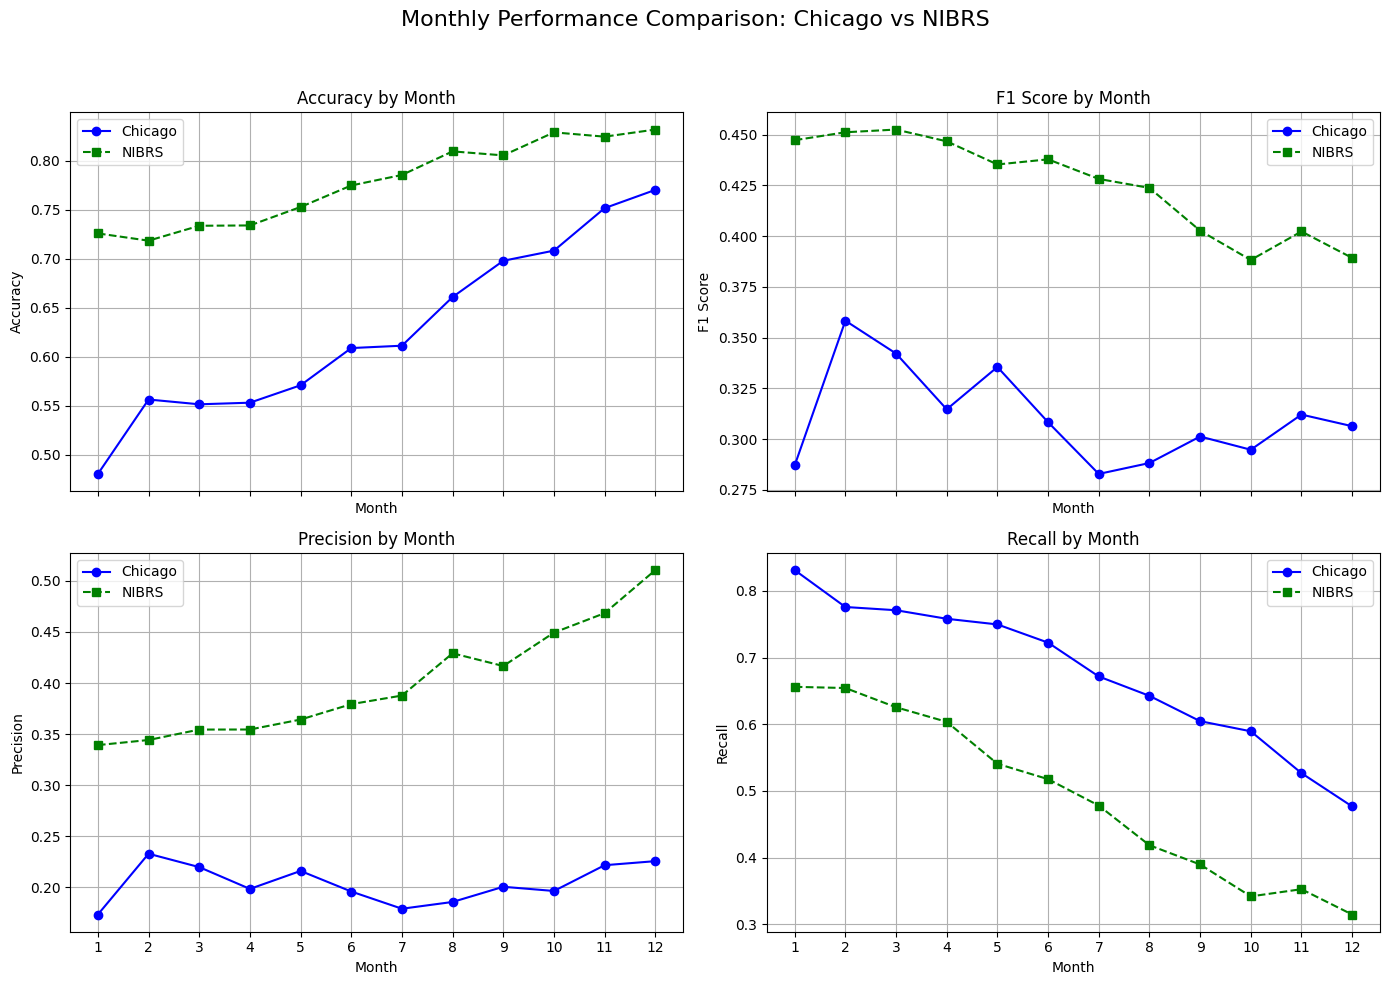

In [45]:
monthly_perf_chicago = monthly_perf_chicago.sort_values(by='month')
monthly_perf_NIBRS = monthly_perf_NIBRS.sort_values(by='month')

months = monthly_perf_chicago['month']

plot_temporal_comparison(
    monthly_perf_chicago, 
    monthly_perf_NIBRS, 
    x_col='month', 
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='Monthly'
)

### Evaluate Performance in Weekend

In [46]:
# Evaluate performance in Month for Chicago test set
weekend_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='is_weekend')
print("Performance in is_weekend for Chicago test set: \n", weekend_perf_chicago)
# Evaluate performance in Month for NIBRS test set
weekend_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='is_weekend')
print("Performance in is_weekend for NIBRS test set: \n", weekend_perf_NIBRS)

Performance in is_weekend for Chicago test set: 
    is_weekend  accuracy  f1_score  precision    recall    count
0           0  0.743627  0.356404   0.255220  0.590519  64055.0
1           1  0.356706  0.260269   0.152176  0.898452  25643.0
Performance in is_weekend for NIBRS test set: 
    is_weekend  accuracy  f1_score  precision    recall     count
0           0  0.804702  0.418548   0.409986  0.427475  402457.0
1           1  0.713841  0.447391   0.347590  0.627582  160519.0


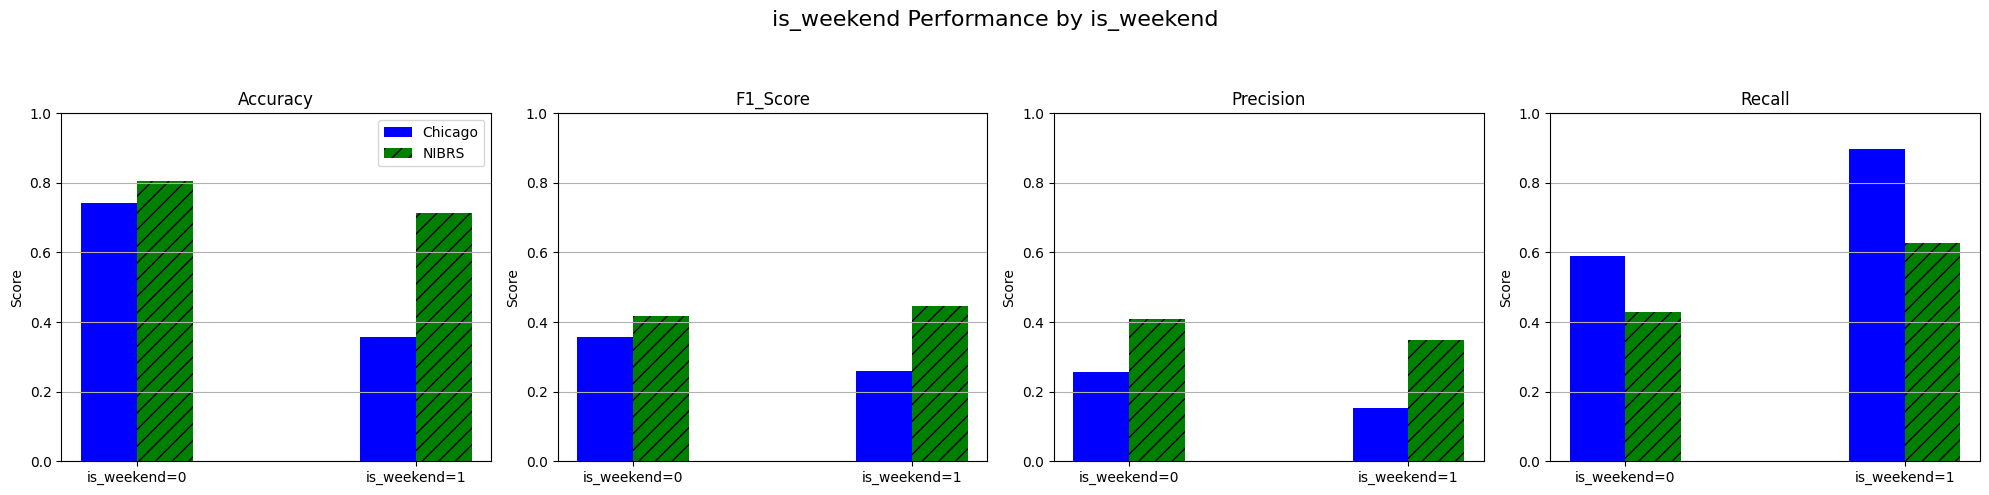

In [47]:
weekend_perf_chicago = weekend_perf_chicago.sort_values(by='is_weekend')
weekend_perf_NIBRS = weekend_perf_NIBRS.sort_values(by='is_weekend')

plot_binary_group_bars_split(
    weekend_perf_chicago, 
    weekend_perf_NIBRS, 
    group_col='is_weekend', 
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='is_weekend'
)

### Evaluate performance in is_holiday

In [48]:
# Evaluate performance in Holiday for Chicago test set
holiday_perf_chicago = evaluate_temporal_performance(eval_df_chicago, group_col='is_holiday')
print("Performance in is_holiday for Chicago test set: \n", holiday_perf_chicago)
# Evaluate performance in Holiday for NIBRS test set
holiday_perf_NIBRS = evaluate_temporal_performance(eval_df_NIBRS, group_col='is_holiday')
print("Performance in is_holiday for NIBRS test set: \n", holiday_perf_NIBRS)

Performance in is_holiday for Chicago test set: 
    is_holiday  accuracy  f1_score  precision    recall    count
0           0  0.635094  0.311989   0.202246  0.682127  86214.0
1           1  0.581515  0.302392   0.195424  0.668076   3484.0
Performance in is_holiday for NIBRS test set: 
    is_holiday  accuracy  f1_score  precision    recall     count
0           0  0.779826  0.429981   0.384250  0.488067  543510.0
1           1  0.750026  0.418221   0.347437  0.525225   19466.0


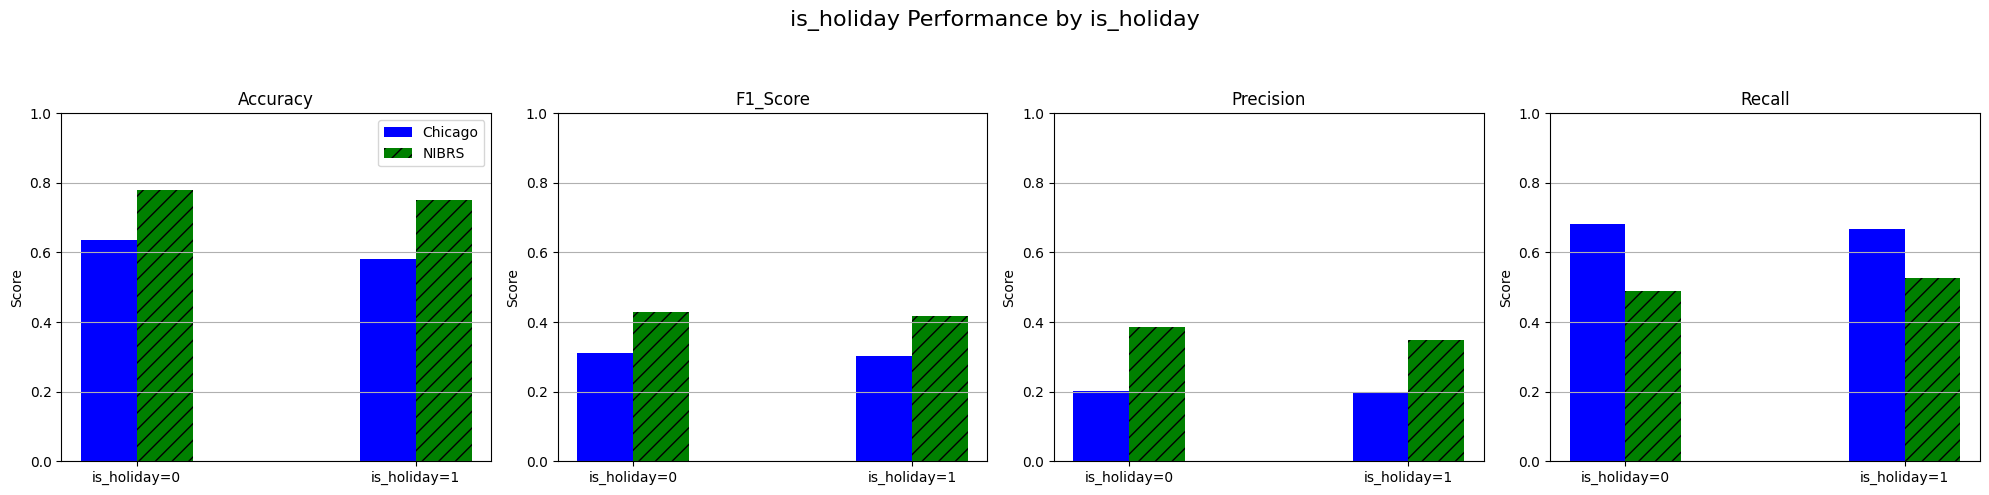

In [49]:
holiday_perf_chicago = holiday_perf_chicago.sort_values(by='is_holiday')
holiday_perf_NIBRS = holiday_perf_NIBRS.sort_values(by='is_holiday')

plot_binary_group_bars_split(
    holiday_perf_chicago, 
    holiday_perf_NIBRS, 
    group_col='is_holiday',
    dataset_names=('Chicago', 'NIBRS'), 
    title_prefix='is_holiday'
)

## Spatial Accuracy Evaluation

In [50]:
unified_location_mapping = {
    "Residence": 1,
    "Street/Outdoor": 2,
    "Transportation Hub": 3,
    "Retail/Commercial": 4,
    "Entertainment": 5,
    "Government/Public": 6,
    "Medical Facility": 7,
    "Workplace/Office": 8,
    "Parking Lot": 9,
    "Unknown/Other": 10
}
reverse_location_mapping = {v: k for k, v in unified_location_mapping.items()}

In [51]:
eval_df_chicago['location_name'] = eval_df_chicago['UNIFIED_LOCATION_CODE'].map(reverse_location_mapping)
eval_df_NIBRS['location_name'] = eval_df_NIBRS['UNIFIED_LOCATION_CODE'].map(reverse_location_mapping)

In [52]:
def evaluate_spatial_performance(df, group_col='location_name', y_true_col='y_true', y_pred_col='y_pred'):
    grouped_perf = df.groupby(group_col).apply(
        lambda g: pd.Series({
            'accuracy': accuracy_score(g[y_true_col], g[y_pred_col]),
            'f1_score': f1_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'precision': precision_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'recall': recall_score(g[y_true_col], g[y_pred_col], zero_division=0),
            'count': len(g)
        })
    ).reset_index().sort_values(by='f1_score', ascending=False)
    
    return grouped_perf

In [53]:
def plot_spatial_performance_comparison(df1, df2, metric='f1_score', dataset_names=('Chicago', 'NIBRS')):

    merged = df1[['location_name', metric]].merge(
        df2[['location_name', metric]],
        on='location_name',
        suffixes=(f'_{dataset_names[0]}', f'_{dataset_names[1]}')
    )

    locations = merged['location_name']
    vals1 = merged[f'{metric}_{dataset_names[0]}']
    vals2 = merged[f'{metric}_{dataset_names[1]}']

    x = np.arange(len(locations))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.barh(x - width/2, vals1, height=width, label=dataset_names[0], color='blue')
    ax.barh(x + width/2, vals2, height=width, label=dataset_names[1], color='green')

    ax.set_yticks(x)
    ax.set_yticklabels(locations)
    ax.invert_yaxis()
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()} by Location ({dataset_names[0]} vs {dataset_names[1]})')
    ax.legend()
    ax.grid(axis='x')
    plt.tight_layout()
    plt.show()

In [54]:
chicago_spatial_perf = evaluate_spatial_performance(eval_df_chicago)
print("Spatial Performance for Chicago test set: \n", chicago_spatial_perf)
NIBRS_spatial_perf = evaluate_spatial_performance(eval_df_NIBRS)
print("Spatial Performance for NIBRS test set: \n", NIBRS_spatial_perf)

Spatial Performance for Chicago test set: 
         location_name  accuracy  f1_score  precision    recall    count
1   Government/Public  0.798742  0.737705   0.692308  0.789474    159.0
6      Street/Outdoor  0.634921  0.421946   0.285858  0.805345  31889.0
2    Medical Facility  0.616412  0.365931   0.257778  0.630435    524.0
7  Transportation Hub  0.592705  0.304498   0.208038  0.567742    987.0
0       Entertainment  0.499184  0.303855   0.191429  0.736264    613.0
3         Parking Lot  0.738383  0.282723   0.179601  0.663934   3142.0
8       Unknown/Other  0.677595  0.249485   0.160727  0.557168  29373.0
5   Retail/Commercial  0.633880  0.247191   0.190531  0.351812   2745.0
9    Workplace/Office  0.712695  0.198758   0.120907  0.558140   1347.0
4           Residence  0.542788  0.186724   0.110321  0.607339  18919.0
Spatial Performance for NIBRS test set: 
         location_name  accuracy  f1_score  precision    recall     count
6      Street/Outdoor  0.818732  0.609790   0.519

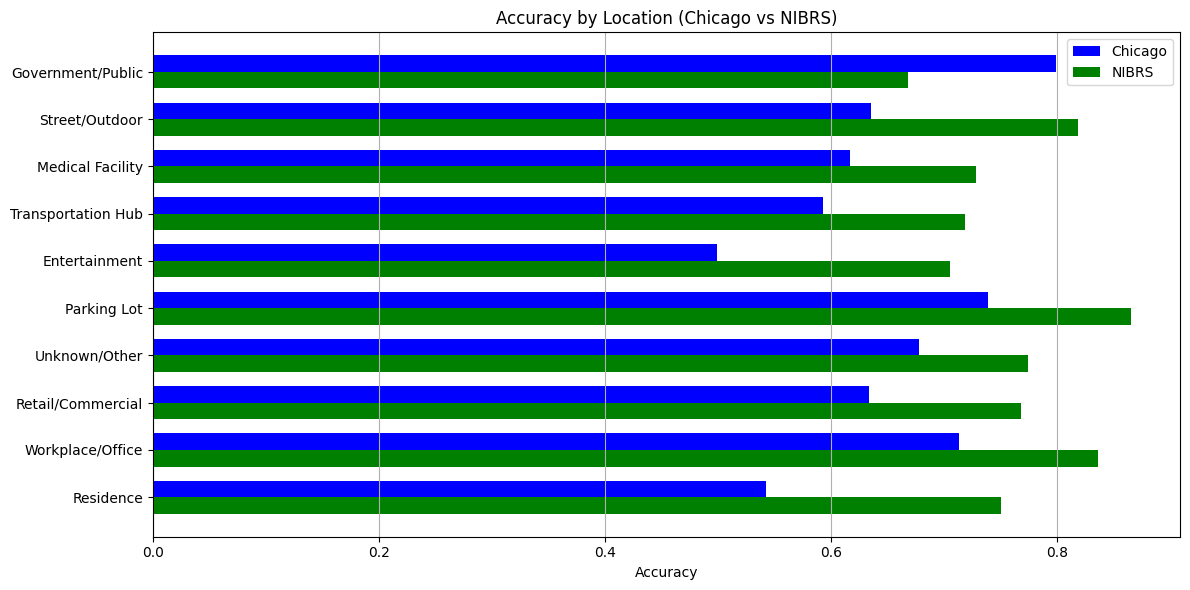

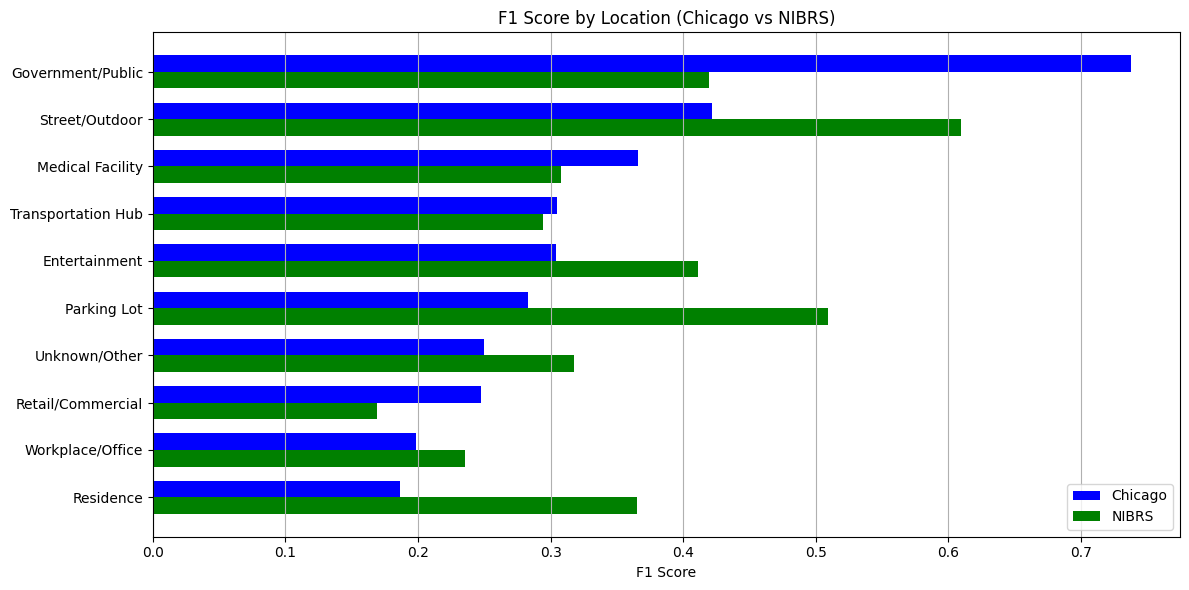

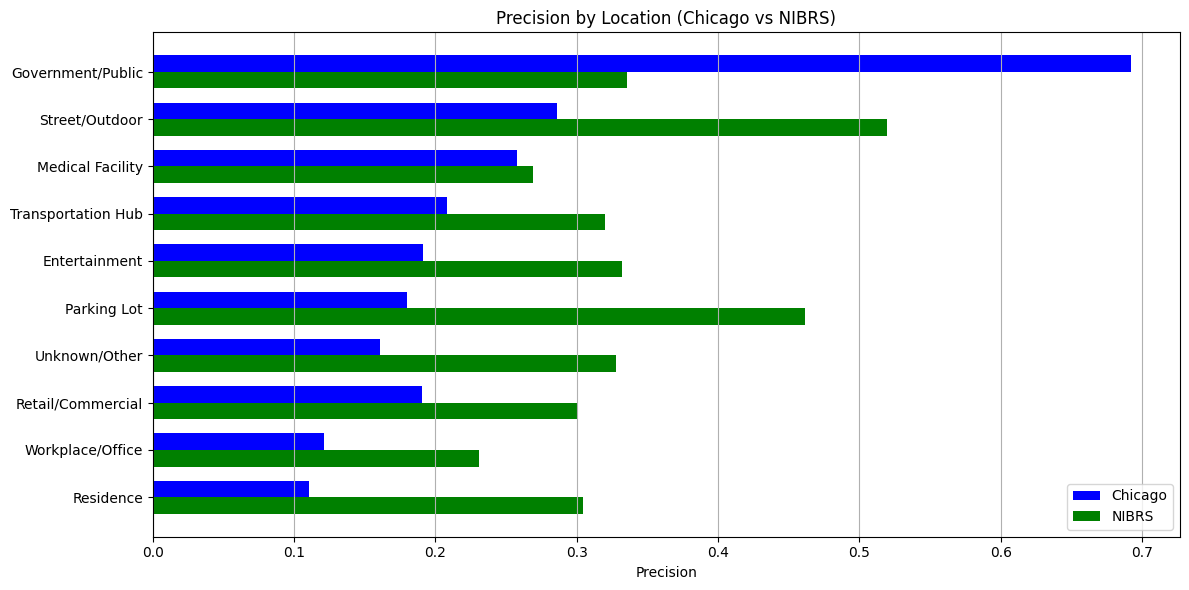

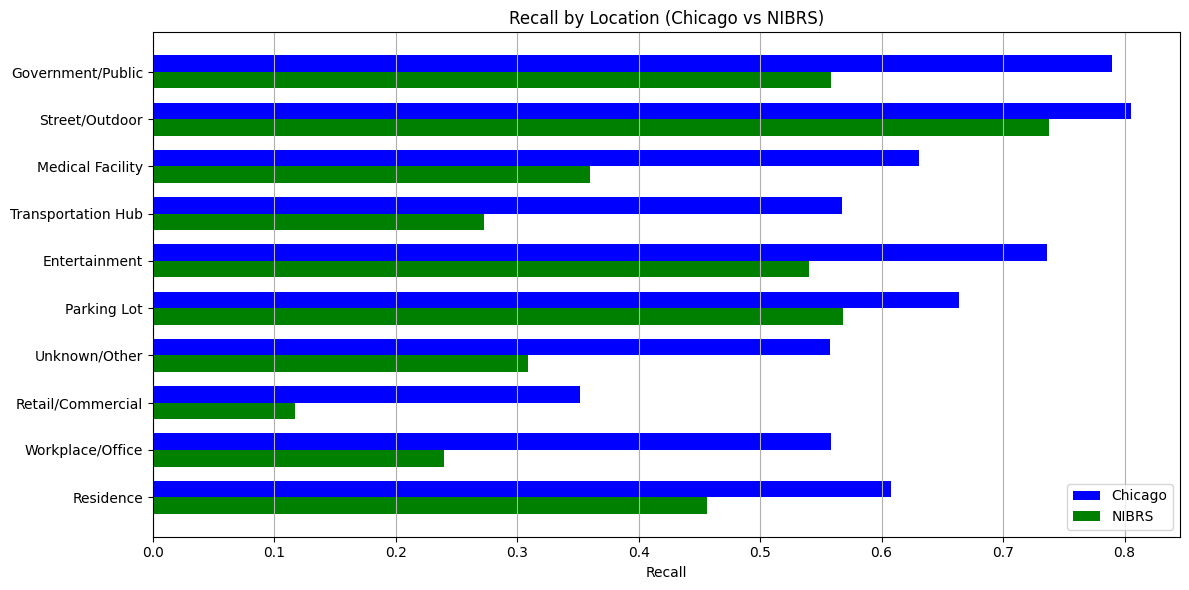

In [55]:
metrics = ['accuracy', 'f1_score', 'precision', 'recall']

for metric in metrics:
    plot_spatial_performance_comparison(
        chicago_spatial_perf,
        NIBRS_spatial_perf,
        metric=metric,
        dataset_names=('Chicago', 'NIBRS')
    )
# plot_spatial_performance_bar(spatial_perf, metric='accuracy')